In [96]:
import pandas as pd
import numpy as np
from collections import Counter
import re
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import random
import zipfile
import gc


Fixing random seed for reproducibility

In [97]:
def set_seed():
    np.random.seed(42)
    random.seed(42)
    
set_seed()

Import data from .CSV files to panda dataframes

In [98]:
column_names = ['class', 'text']

training_set = pd.read_csv('data/train.csv', names = column_names)
development_set = pd.read_csv('data/dev.csv', names = column_names)
test_set = pd.read_csv('data/test.csv', names = column_names)

List of stop words 

In [99]:
stop_words = ['a','in','on','at','and','or', 
              'to', 'the', 'of', 'an', 'by', 
              'as', 'is', 'was', 'were', 'been', 'be', 
              'are','for', 'this', 'that', 'these', 'those', 'you', 'i', 'if',
             'it', 'he', 'she', 'we', 'they', 'will', 'have', 'has',
              'do', 'did', 'can', 'could', 'who', 'which', 'what',
              'but', 'not', 'there', 'no', 'does', 'not', 'so', 've', 'their',
             'his', 'her', 'they', 'them', 'from', 'with', 'its']

Function that extracts unigrams from a document


In [100]:
def extract_ngrams(x_raw, ngram_range=(1,3), token_pattern=r'\b[A-Za-z][A-Za-z]+\b', 
                   stop_words=[], vocab=set()):
    
    # Tokenize string into list of unigrams
    tokens = re.findall(token_pattern, x_raw)
    tokens = [token.lower() for token in tokens]
    
    # Remove stop words
    if stop_words:
        tokens = [token for token in tokens if token not in stop_words]
    
    x = []
    
    # Extract n-grams
    for n in range(ngram_range[0], ngram_range[1] + 1):
        for i in range(len(tokens) - n + 1):
            ngram = ' '.join(tokens[i:i + n])
            if vocab:
                if ngram in vocab:
                    x.append(ngram)
            else:
                x.append(ngram)
         
    return x

Create vocabulary of ngrams from list of documents

In [101]:
def get_vocab(X_raw, ngram_range=(1,3), token_pattern=r'\b[A-Za-z][A-Za-z]+\b', 
              min_df=0, keep_topN=0, 
              stop_words=[]):
    
    df = Counter()
    ngram_counts = Counter()
    
    # Extract ngrams, document frequencies, and raw frequencies
    for document in X_raw:
        ngrams = extract_ngrams(document, ngram_range, token_pattern, stop_words)
        
        # Update document frequencies
        df.update(set(ngrams))
        
        # Update ngram counts
        ngram_counts.update(ngrams)

    # Filter ngrams based on min_df
    if min_df > 0:
        ngrams_to_remove = [ngram for ngram, freq in df.items() if freq < min_df]
    
        for ngram in ngrams_to_remove:
            df.pop(ngram)
            ngram_counts.pop(ngram)

    # Keep top-N frequent ngrams
    if keep_topN > 0:
        ngram_counts = dict(ngram_counts.most_common(keep_topN))
        df = {ngram: freq for ngram, freq in df.items() if ngram in ngram_counts}

    # Extract vocabulary
    vocab = set(df.keys())
    
    return vocab, df, ngram_counts

In [102]:
vocab, df, ngram_counts = get_vocab(training_set['text'], ngram_range=(1,1), stop_words=stop_words)

Vocabulary id -> word and word -> vocabulary id dictionaries for reference:

In [103]:
id2word = {i:word for i, word in enumerate(vocab)}
word2id = {word:i for i, word in enumerate(vocab)}

print(id2word)
print(word2id)

{0: 'imminent', 1: 'attraction', 2: 'kind', 3: 'twist', 4: 'stroke', 5: 'corner', 6: 'airlifted', 7: 'prison', 8: 'rooting', 9: 'citron', 10: 'tycoon', 11: 'propose', 12: 'varazdates', 13: 'braced', 14: 'calendar', 15: 'sixty', 16: 'sacred', 17: 'presence', 18: 'islamic', 19: 'lection', 20: 'expand', 21: 'lifeboats', 22: 'locked', 23: 'saviour', 24: 'lakers', 25: 'celebration', 26: 'toppled', 27: 'uniting', 28: 'latches', 29: 'messaging', 30: 'terrorism', 31: 'authorities', 32: 'austin', 33: 'smashed', 34: 'policemen', 35: 'bar', 36: 'demonstrators', 37: 'gruden', 38: 'district', 39: 'voted', 40: 'curbs', 41: 'superiority', 42: 'injury', 43: 'scenes', 44: 'improbable', 45: 'defender', 46: 'janus', 47: 'dislocating', 48: 'weston', 49: 'nascar', 50: 'whopping', 51: 'satellites', 52: 'dropping', 53: 'hazem', 54: 'builders', 55: 'wussy', 56: 'russian', 57: 'frontier', 58: 'into', 59: 'testing', 60: 'jews', 61: 'marines', 62: 'shaalan', 63: 'dare', 64: 'club', 65: 'griffey', 66: 'offseason'

Represent documents in train, dev and test sets as lists of words in the vocabulary

In [104]:
# Convert a document to a list of words
def document_to_words(document):
    words = document.split()
    words_in_vocab= []
    for word in words:
        if word in vocab:
            words_in_vocab.append(word)

    return words_in_vocab

# Represent documents as lists of words
training_documents = [document_to_words(document) for document in training_set['text']]
development_documents = [document_to_words(document) for document in development_set['text']]
test_documents = [document_to_words(document) for document in test_set['text']]

Convert them into lists of indices in the vocabulary

In [105]:
# Convert a list of words into a list of indices
def document_to_indices(document):
    word_indices = []
    for word in document:
        if word in vocab:
            word_indices.append(word2id[word])

    return word_indices

# Represent lists of words as lists of indices
X_tr = np.array([document_to_indices(document) for document in training_documents], dtype=object)
X_dev = np.array([document_to_indices(document) for document in development_documents], dtype=object)
X_te = np.array([document_to_indices(document) for document in test_documents], dtype=object )

Put labels for train, dev and test sets into arrays (subtrack 1 to make labels 0-based)

In [106]:
# Store labels and subtrack 1 so they are 0-based
Y_tr = np.array([y - 1 for y in training_set['class']])
Y_dev = np.array([y - 1 for y in development_set['class']])
Y_te = np.array([y - 1 for y in test_set['class']])

Remove empty documends

In [107]:
non_empty_doc_indices = np.where(np.array([len(x) != 0 for x in X_tr]))[0]

X_tr =  X_tr[non_empty_doc_indices]
Y_tr = Y_tr[non_empty_doc_indices]

non_empty_doc_indices = np.where(np.array([len(x) != 0 for x in X_dev]))[0]

X_dev =  X_dev[non_empty_doc_indices]
Y_dev = Y_dev[non_empty_doc_indices]

non_empty_doc_indices = np.where(np.array([len(x) != 0 for x in X_te]))[0]

X_te =  X_te[non_empty_doc_indices]
Y_te = Y_te[non_empty_doc_indices]

Initialise the weights of the embedding matrix and the hidden layer matrices.

In [108]:
def network_weights(vocab_size=1000, embedding_dim=300, 
                    hidden_dim=[], num_classes=3, init_val = 0.5):

    # Weight matrices
    W = {}
    
    # Initialize embedding matrix
    W[0] = np.random.uniform(-init_val, init_val, (vocab_size, embedding_dim)).astype(np.float64)
    
    # Initialize hidden layers
    if len(hidden_dim) > 0:
        for i in range(len(hidden_dim)):
            if i == 0:
                W[i + 1] = np.random.uniform(-init_val, init_val, (embedding_dim, hidden_dim[i])).astype(np.float64)
            else:
                W[i + 1] = np.random.uniform(-init_val, init_val, (hidden_dim[i - 1], hidden_dim[i])).astype(np.float64)
    
    # Initialize output layer
    if len(hidden_dim) > 0:
        W[len(hidden_dim) + 1] = np.random.uniform(-init_val, init_val, (hidden_dim[-1], num_classes)).astype(np.float64)
    else:
        W[1] = np.random.uniform(-init_val, init_val, (embedding_dim, num_classes)).astype(np.float64)

    return W
    

In [109]:
W = network_weights(vocab_size=100,embedding_dim=4, 
                    hidden_dim=[200, 100], num_classes=2)

for i in range(len(W)):
    print(f'W[{i}].shape = {W[i].shape}')

del W
gc.collect()

W[0].shape = (100, 4)
W[1].shape = (4, 200)
W[2].shape = (200, 100)
W[3].shape = (100, 2)


9121

Softmax function adapted from the pytorch implementation

In [110]:
# Softmax function adapted from the pytorch implementation
def softmax(z):
    
    max_val = np.max(z)
    z_exp = np.exp(z - max_val)
    sig = z_exp / np.sum(z_exp)
    return sig

Categorical cross entropy loss and its gradient


In [111]:
def categorical_loss(y, y_preds):

    epsilon = 1e-10

    y_onehot = np.zeros_like(y_preds)
    y_onehot[y] = 1
    
    l = -np.sum(y_onehot * np.log(y_preds + epsilon)) / len(y_preds)

    return l

def grad_categorical_loss(y, y_preds):

    y_onehot = np.zeros_like(y_preds)
    y_onehot[y] = 1
    
    grad = (y_preds - y_onehot) / len(y_preds)
    
    return grad

Relu activation function and its derivative

In [112]:
def relu(z):

    z_copy = np.copy(z)
    
    a = np.maximum(z_copy, 0) 

    return a
    
def relu_derivative(z):

    z_copy = np.copy(z)
    dz = np.where(z_copy <= 0, 0, 1)
    
    return dz

Dropout mask

In [113]:
def dropout_mask(size, dropout_rate):

    dropout_vec = []

    for i in range(size):
        if np.random.rand() < dropout_rate:
            dropout_vec.append(0)
        else:
            dropout_vec.append(1)
    
    return dropout_vec

Forward pass

In [114]:
def forward_pass(x, W, dropout_rate=0.2):
  
    out_vals = {}

    h_vecs = []
    a_vecs = []
    dropout_vecs = []

    num_layers = len(W) - 1

    a = x
    a_vecs.append(a)

    sum_h = 0
    for i in x:
        sum_h += W[0][i]

    # Pass input through embedding layer
    h = sum_h / len(x)
    a = relu(h)

    dropout = dropout_mask(a.shape[0], dropout_rate) 
    a *= dropout

    # Store values for the first layer
    h_vecs.append(h)
    a_vecs.append(a)
    dropout_vecs.append(dropout)

    # Pass through the rest of the layers
    for i in range(1, num_layers):
        h = np.dot(a, W[i])
        a = relu(h)

        dropout = dropout_mask(a.shape[0], dropout_rate) 
        a *= dropout
        
        # Store values for this layer
        h_vecs.append(h)
        a_vecs.append(a)
        dropout_vecs.append(dropout)
        
    # Compute output layer
    h = np.dot(a, W[num_layers])
    y = softmax(h)

    h_vecs.append(h)
    a_vecs.append(y)

    # Store output layer values
    out_vals['h'] = h_vecs
    out_vals['a'] = a_vecs
    out_vals['dropout'] = dropout_vecs
    out_vals['y'] = y

    return out_vals

Backward pass  

In [115]:
def backward_pass(x, y, W, out_vals, lr=0.001, freeze_emb=False):

    h_vecs = out_vals['h']
    a_vecs = out_vals['a']
    y_pred = out_vals['y']
    
    num_layers = len(W) - 1
    num_samples = len(x)

    # Compute gradient on the output layer
    g = grad_categorical_loss(y, y_pred)
    
    # Compute gradients for layers and update weights
    for i in range(num_layers, -1, -1):
        
        # If updating embedding layer
        if i == 0:
            if freeze_emb:
                continue
            else:
                g *= np.array(relu_derivative(h_vecs[i]))
                dl_dW = g / num_samples
                for j in x:
                    W[i][j] -= lr * dl_dW

        else:

            g *= np.array(relu_derivative(h_vecs[i]))

            dl_dW = g * a_vecs[i].reshape(-1, 1)
       
            g = np.dot(g, W[i].T) 

            W[i] -= lr * dl_dW 

    return W

Stohastic gradient descent

In [116]:
def SGD(X_tr, Y_tr, W, X_dev=[], Y_dev=[], lr=0.001, 
        dropout=0.2, epochs=5, tolerance=0.001, freeze_emb=False, 
        print_progress=True):
    
    training_loss_history = []
    validation_loss_history = []

    prev_validation_loss = 0

    for epoch in range(epochs):
        # Training loop and loss
        indices = np.arange(len(X_tr))
        np.random.shuffle(indices)
        training_loss = 0
        for idx in indices:
            x = X_tr[idx]
            y = Y_tr[idx]
            out_vals = forward_pass(x, W, dropout_rate = dropout)
            W = backward_pass(x, y, W, out_vals, lr, freeze_emb)
            training_loss += categorical_loss(y, out_vals['y'])
        training_loss_history.append(training_loss)

        # Validation loop and loss
        if len(X_dev) > 0 and len(Y_dev) > 0:
            indices_dev = np.arange(len(X_dev))
            np.random.shuffle(indices_dev)
            validation_loss = 0
            for idx in indices_dev:
                x_dev = X_dev[idx]
                y_dev = Y_dev[idx]
                out_vals_dev = forward_pass(x_dev, W, dropout_rate=dropout)
                validation_loss += categorical_loss(y_dev, out_vals_dev['y'])
            validation_loss_history.append(validation_loss)

        if print_progress:
            print(f'Epoch {epoch + 1}: Training Loss = {training_loss}', end='')
            if len(X_dev) > 0 and len(Y_dev) > 0:
                print(f', Validation Loss = {validation_loss}')
            else:
                print('')
            
        # Check for early stopping
        if tolerance != 'None':
            if epoch > 0 and prev_validation_loss - validation_loss < tolerance:
                print(('Stopped training early at epoch ' 
                f'{epoch + 1} due to convergence.'))
                break
        prev_validation_loss = validation_loss


    return W, training_loss_history, validation_loss_history

# Using pre-trained, GloVe embeddings

This function reads pre-trained ([GloVe](https://nlp.stanford.edu/projects/glove/)) embeddings from a file and returns a dictionary that maps words to their corresponding word vectors. The speciific file used in th code can be downloaded from [here](http://nlp.stanford.edu/data/glove.840B.300d.zip).

In [117]:
def get_glove_embeddings(f_zip, f_txt, word2id, emb_size=300):
    
    w_emb = np.zeros((len(word2id), emb_size))

    error_count = 0
    
    with zipfile.ZipFile(f_zip) as z:
        with z.open(f_txt) as f:
            for line in f:
                line = line.decode('utf-8')
                word = line.split()[0]

                if word in vocab:
                    try:
                        emb = np.array(line.strip('\n').split()[1:]).astype(
                            np.float32)
                        w_emb[word2id[word]] += emb
                    except:
                        error_count += 1

    print(f'Number of errors: {error_count}')
                    
    return w_emb



Training the neural network

In [123]:
W = network_weights(vocab_size=len(vocab),embedding_dim=300,
                    hidden_dim=[], num_classes=3, init_val=0.1)

# Use pre-trained embeddings
# w_glove = get_glove_embeddings('glove.840B.300d.zip', 'glove.840B.300d.txt', word2id, emb_size=300)
# W[0] = w_glove

W, loss_tr, dev_loss = SGD(X_tr, Y_tr,
                            W,
                            X_dev=X_dev, 
                            Y_dev=Y_dev,
                            lr=0.5, 
                            dropout=0.5,
                            freeze_emb=False,
                            tolerance=1e-5,
                            epochs=100)

Epoch 1: Training Loss = 867.2702615846272, Validation Loss = 53.08674753626372
Epoch 2: Training Loss = 714.6444416229867, Validation Loss = 38.65878682416009
Epoch 3: Training Loss = 429.51165536449787, Validation Loss = 26.6391312590142
Epoch 4: Training Loss = 254.0224758681387, Validation Loss = 22.731876129524604
Epoch 5: Training Loss = 156.00943871664717, Validation Loss = 25.218718145691618
Stopped training early at epoch 5 due to convergence.


Ploting the learning process

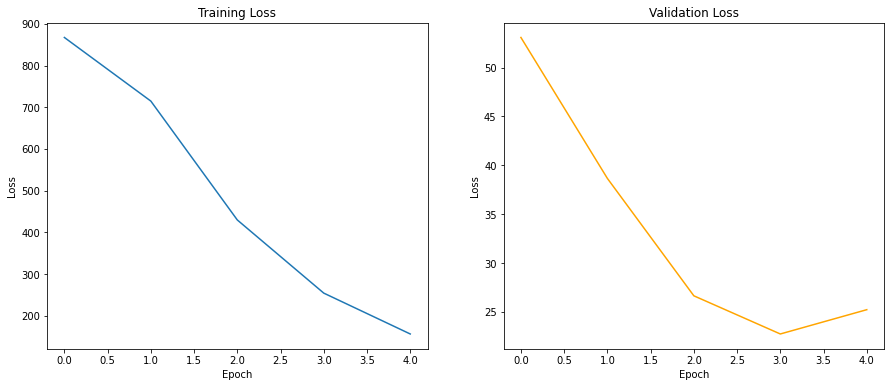

In [124]:
# plot the training and validation loss
%matplotlib inline  

fig, axs = plt.subplots(1, 2, figsize=(15, 6))

axs[0].plot(loss_tr, label='Training Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].title.set_text('Training Loss')

axs[1].plot(dev_loss, label='Validation Loss', color='orange')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].title.set_text('Validation Loss')

plt.show()

Compute accuracy, precision, recall and F1-Score

In [125]:
preds_te_initial_model = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y'])
            for x,y in zip(X_te,Y_te)]

print('Accuracy:', accuracy_score(Y_te,preds_te_initial_model))
print('Precision:', precision_score(Y_te,preds_te_initial_model,average='macro'))
print('Recall:', recall_score(Y_te,preds_te_initial_model,average='macro'))
print('F1-Score:', f1_score(Y_te,preds_te_initial_model,average='macro'))


Accuracy: 0.8166666666666667
Precision: 0.8179210275767638
Recall: 0.8166666666666668
F1-Score: 0.8160055649450779


Plot confusion matrix

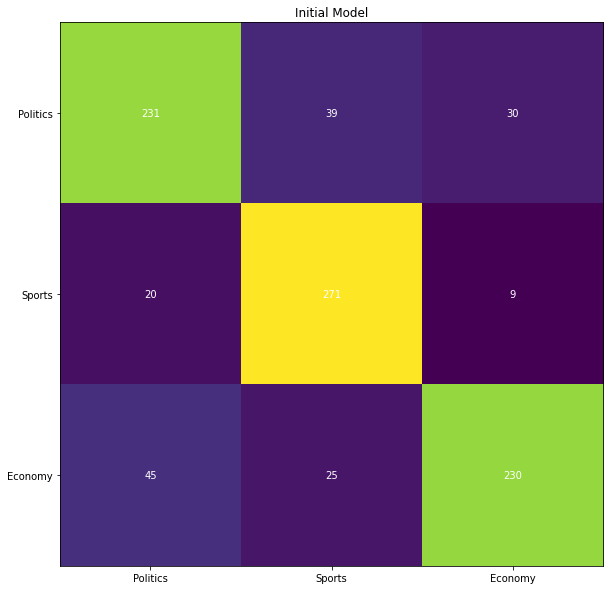

In [121]:
def calculate_confusion_matrix(true_labels, predictions):
    confusion_matrix = np.zeros((np.max(true_labels)+1, 
                                 np.max(true_labels)+1), dtype=int)
    for i in range(len(true_labels)):
        confusion_matrix[true_labels[i], predictions[i]] += 1
    return confusion_matrix


labels = ['Politics', 'Sports', 'Economy']

# Calculate confusion matrices for all three models
confusion_matrix_model = calculate_confusion_matrix(Y_te, preds_te_initial_model)

# Plot confusion matrices

fig = plt.figure(figsize=(10, 10))

# Plot for initial model
plt.imshow(confusion_matrix_model, cmap='viridis', interpolation='nearest')
plt.title('Initial Model')
plt.xticks(np.arange(len(labels)), labels)
plt.yticks(np.arange(len(labels)), labels)
for i in range(len(labels)):
    for j in range(len(labels)):
        plt.text(j, i, confusion_matrix_model[i, j], ha='center', va='center', color='white')




Hyperparameter tuning run using grid search

In [122]:
# set_seed()

# best_f1 = 0
# best_params = (0, 0, 0)

# training_losses = []
# validation_losses = []
# param_lists = []

# for emb in [100, 300]:
#     for lr in [0.5, 0.05]:
#         for dropout in [0.2, 0.5]:
#             # Store the parameter combination
#             param_lists.append((emb, lr, dropout))

#             W = network_weights(vocab_size=len(vocab), embedding_dim=emb,
#                                 hidden_dim=[], num_classes=3, init_val=0.1)

#             W, loss_tr, dev_loss = SGD(X_tr, Y_tr,
#                                         W,
#                                         X_dev=X_dev,
#                                         Y_dev=Y_dev,
#                                         lr=lr,
#                                         dropout=dropout,
#                                         freeze_emb=False,
#                                         tolerance=1e-5,
#                                         epochs=100,
#                                         print_progress=False)

#             # Append training and validation losses to lists
#             training_losses.append(loss_tr)
#             validation_losses.append(dev_loss)

#             preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y'])
#                         for x, y in zip(X_te, Y_te)]

#             f1 = f1_score(Y_te, preds_te, average='macro')
#             if f1 > best_f1:
#                 best_f1 = f1
#                 best_params = (emb, lr, dropout)

#             print((f'Embedding size: {emb}, Learning rate: {lr}, ' 
#                    f'Dropout: {dropout}'))
#             print('Accuracy:', accuracy_score(Y_te, preds_te))
#             print('Precision:', precision_score(Y_te, preds_te, average='macro'))
#             print('Recall:', recall_score(Y_te, preds_te, average='macro'))
#             print('F1-Score:', f1)
#             print('-----------------------------------------------------------------------------------------')

# print(f'Best F1-Score: {best_f1}')
# print(f'Best parameters: {best_params}')

# fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# # Plot training losses
# for i, loss_tr in enumerate(training_losses):
#     axs[0].plot(loss_tr, label=(f'Emb={param_lists[i][0]}, '
#                 f'LR={param_lists[i][1]}, Dropout={param_lists[i][2]}'))
# axs[0].set_xlabel('Epoch')
# axs[0].set_ylabel('Loss')
# axs[0].title.set_text('Training Losses')
# axs[0].legend()

# # Plot validation losses
# for i, dev_loss in enumerate(validation_losses):
#     axs[1].plot(dev_loss, label=(f'Emb={param_lists[i][0]}, '
#                 f'LR={param_lists[i][1]}, Dropout={param_lists[i][2]}'))
# axs[1].set_xlabel('Epoch')
# axs[1].set_ylabel('Loss')
# axs[1].title.set_text('Validation Losses')
# axs[1].legend()

# plt.show()